In [29]:
'''
Script to estimate cases responsible per cladeas calculated the frequency of the clade * cases
sequence data pulled from GISAID for all Cook county, cases pulled from IDPH.
'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

#sequence data pulled from GISAID, case data pulled from IDPH
cook_county = pd.read_csv('/Users/tlh4362/Desktop/cook_county_clades.csv')
idph = pd.read_csv('/Users/tlh4362/Desktop/cook_county_cases.csv')


In [30]:
cook_county['clade'] = cook_county['clade'].replace({'20I (Alpha':'20I (Alpha)','20J (Gamma':'20J (Gamma)' })

In [31]:
cases = idph.filter(regex = 'Cases').sum(axis = 1)

idph = pd.DataFrame.from_dict({'Date' : idph['ReportDate'], 'Cases': cases})
idph['Date'] = pd.to_datetime(idph['Date'])

In [32]:
cook_county['date'] = pd.to_datetime(cook_county['date'])

In [33]:
cook_county = cook_county[(cook_county['date'] >= pd.to_datetime('2020-03-17')) & (cook_county['date'] <= pd.to_datetime('2022-03-17'))]




In [34]:
cook_county['clade']= cook_county['clade'].replace({
    '21J (Delta)' : '21J/I/A (Delta)',
    '21I (Delta)' : '21J/I/A (Delta)',
    '21A (Delta)' : '21J/I/A (Delta)',
    '21K (Omicron)' : '21M/K/L (Omicron)',
    '21L (Omicron)' : '21M/K/L (Omicron)',
    '21M (Omicron)' : '21M/K/L (Omicron)',
    '22C (Omicron)' : '21M/K/L (Omicron)',
    '20E (EU1)'     : 'Other',
    '21B (Kappa)'   : 'Other',
    '20H (Beta'     : 'Other',
    'recombinant'   : 'Other',
    '21C (Epsilon)' : 'Other',     
    '19B'           : 'Other',      
    '21F (Iota)'    : 'Other',
    '21H (Mu)'      : 'Other',       
    '20H (Beta, V2)': 'Other',       
    '19A'           : 'Other',     
    '21G (Lambda)'  : 'Other',      
    '20D'           : 'Other',
})

In [35]:

end_date = cook_county['date'].sort_values().unique()[-1]

start = pd.to_datetime('2020-03-17')

weekly_counts = pd.DataFrame()
end = start + datetime.timedelta(days = 7)

while end <= end_date:
    end = start + datetime.timedelta(days = 7)
    tmp = cook_county[(cook_county['date']>=start) & (cook_county['date']<end)]
    week = '{} to {}'.format(str(start).split('00:')[0], str(end).split('00:')[0])
    for clade, count in zip(tmp['clade'].value_counts().index, tmp['clade'].value_counts().values):
        weekly_counts.at[week, clade] = count
    start = end

In [36]:
#calculating weeks it would take to reach certain frequencies

threshold_df = pd.DataFrame()

estimated_clade_cases_df = pd.DataFrame()

for threshold in [0.5, 0.75, 0.95]:
    for clade in weekly_counts.columns:
        tmp = []
        for week in weekly_counts.index:
            count = weekly_counts.loc[week, clade]
            total = weekly_counts.loc[week, :].sum()
            proportion = count/total
            ##################################
            #dealing with clades case estimates
            ##################################
            week_start = pd.to_datetime(week.split('to')[0])
            week_end = pd.to_datetime(week.split('to')[1])
            week_total_cases = idph[(idph['Date'] >= week_start) & (idph['Date'] < week_end)]['Cases'].sum()
            estimated_cases = week_total_cases * proportion
            estimated_clade_cases_df.at[week, clade] = estimated_cases
            
            ##################################
            #dealing with clades case estimates
            ##################################
            
            
            if count >= 10: #check if there are at least 10 samples
                if proportion >= threshold: #check whether the clade reaches dominance
                    first = list(weekly_counts.index).index(weekly_counts[clade].dropna().index[0])
                    week_threshold = list(weekly_counts.index).index(week)
                    tmp.append(week_threshold - first)
        if len(tmp) > 0:
            threshold_df.at[clade, threshold] = min(tmp)

In [37]:
#calculating cumulative estimated cases per clade
estimated_clade_cases_df = estimated_clade_cases_df.cumsum()

In [38]:
#calculating weeks from first detection to reaching thresholds
est_cases_threshold_df = pd.DataFrame()
for threshold in [10000, 50000,100000, 200000]:
    for c in estimated_clade_cases_df.columns:
        diff_list = []
        for d in range(len(estimated_clade_cases_df[c].dropna())):
            date = estimated_clade_cases_df[c].dropna().index[d]
            est_cases = estimated_clade_cases_df[c].dropna().iloc[d]

            if est_cases > threshold:
                week_reached_threshold = list(estimated_clade_cases_df[c].dropna().index).index(date)
                week_first_detection = list(estimated_clade_cases_df[c].dropna().index).index(estimated_clade_cases_df[c].dropna().index[0])
                diff = week_reached_threshold - week_first_detection
                diff_list.append(diff)
        if len(diff_list) > 0:
            est_cases_threshold_df.at[c, threshold] =  min(diff_list)
            
            

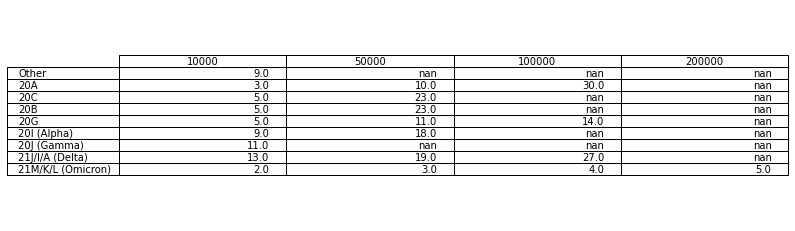

In [39]:
from matplotlib.backends.backend_pdf import PdfPages

fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=est_cases_threshold_df.values,colLabels=est_cases_threshold_df.columns,rowLabels=est_cases_threshold_df.index , loc='center')

# pp = PdfPages('/Users/tlh4362/Desktop/est_cases.pdf')
# pp.savefig(fig, bbox_inches = 'tight')
# pp.close()

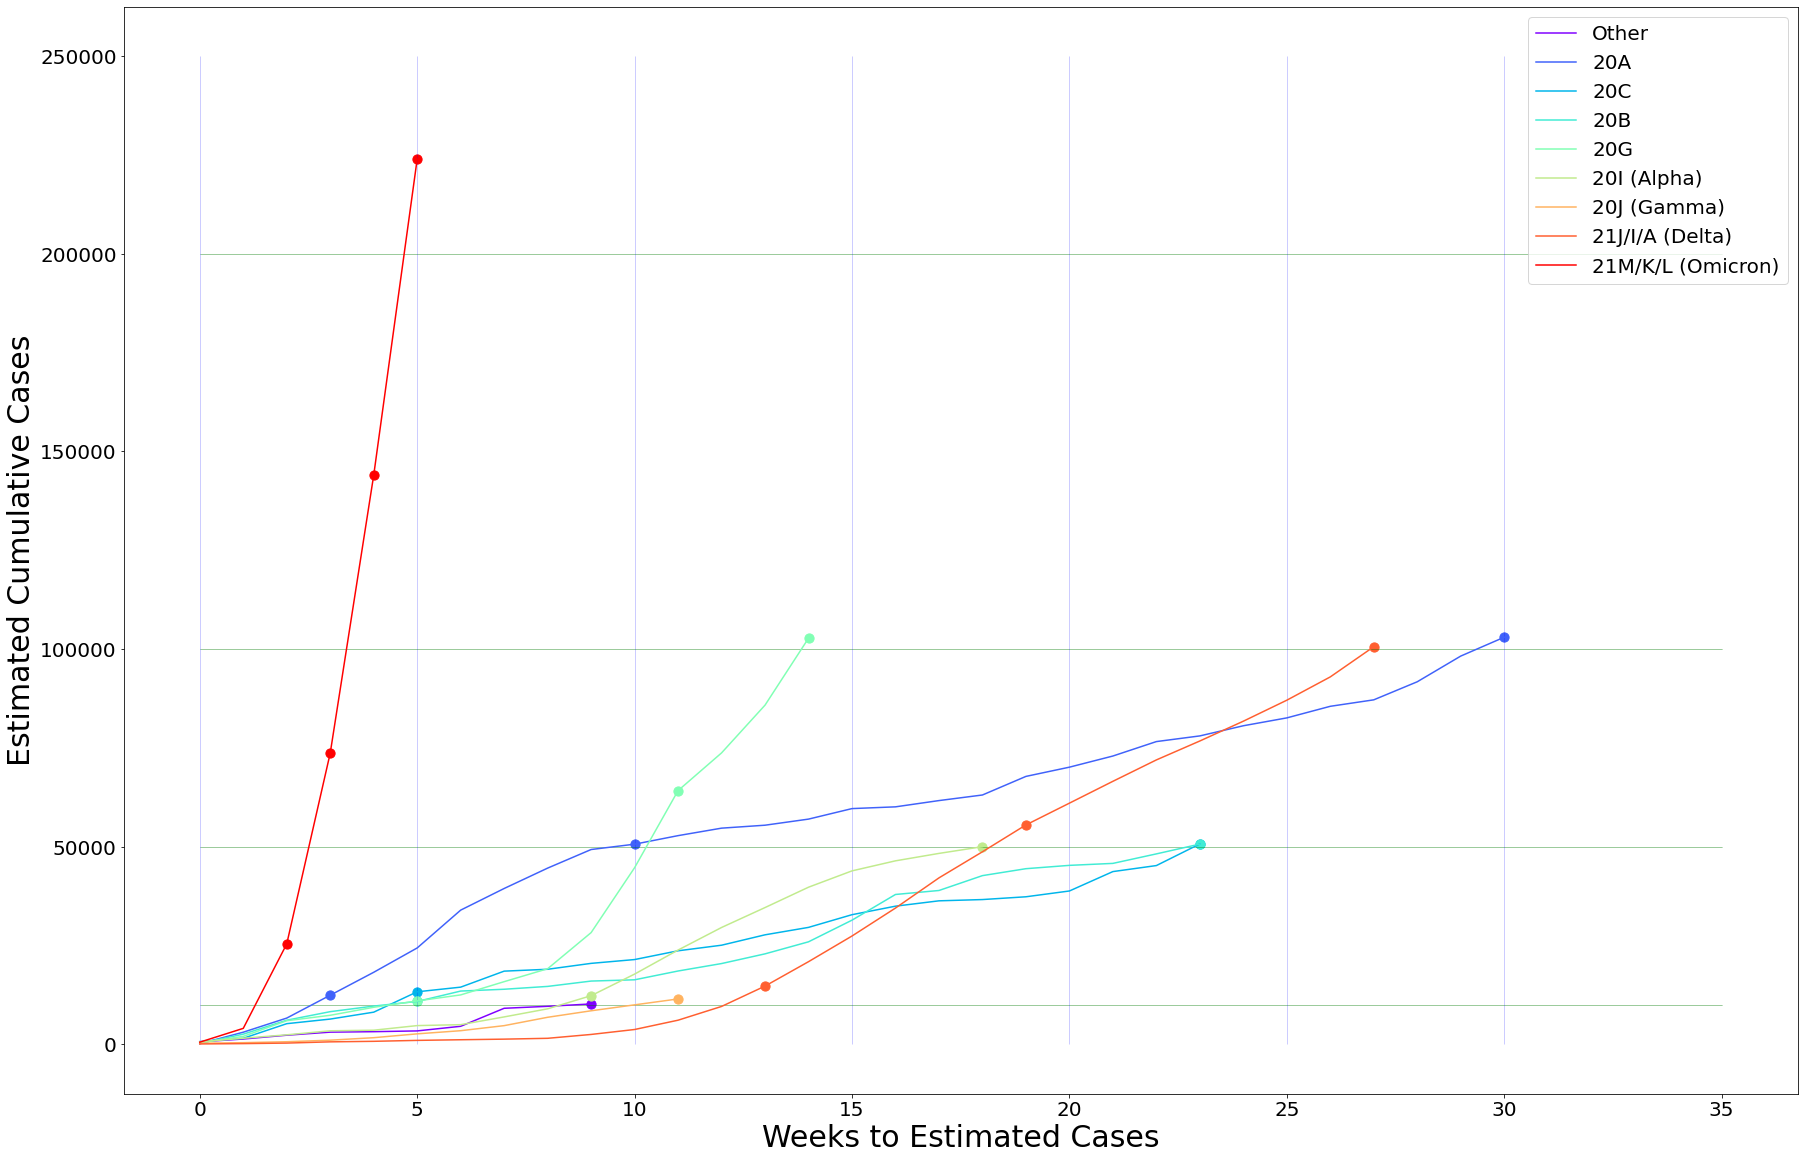

In [40]:
import math
from matplotlib.pyplot import cm


color = cm.rainbow(np.linspace(0, 1, len(est_cases_threshold_df.index)))
plt.figure(figsize = [30,20])
for clade, c in zip(est_cases_threshold_df.index, color):
    week_reached = int(est_cases_threshold_df.loc[clade, :].max()) +1
    tmp = estimated_clade_cases_df[clade].dropna().iloc[0:week_reached]
    tmp = tmp.reset_index(drop = True)
    plt.plot(tmp, label = clade, color = c)
    for threshold in est_cases_threshold_df.columns:
        plt.hlines(y = threshold, xmin = 0, xmax = 35, linewidth = 1, color = 'g', alpha = 0.05)
        week_needed = est_cases_threshold_df.loc[clade, threshold] 
        if math.isnan(week_needed) == False:
            plt.scatter(week_needed, estimated_clade_cases_df[clade].dropna().iloc[int(week_needed)], color = c, s = 85)

for i in range(0,35,5):
    plt.vlines(x = i, ymin = 0, ymax = 250000, linewidth = 1, color = 'b', alpha = 0.2)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.xlabel('Weeks to Estimated Cases', fontsize = 30)
plt.ylabel('Estimated Cumulative Cases', fontsize = 30)
plt.legend(fontsize = 20) 
# plt.savefig('/Users/tlh4362/Desktop/est_cases_1.eps', format = 'eps')
